# Cluster Heatmaps

In [4]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs, TSNEPlot
from larval_gonad.config import memory

# Setup notebook
nbconfig = Nb.setup_notebook(subproject_dir='../output/paper_submission', 
                             seurat_dir='../output/combined_testis_force',
                             formats=['pdf', ],
                             styles=['notebook', 'paper']
                            )

last updated: 2018-05-03 
Git hash: b06784b4f25bb9f06dc5724b481bff901104b4da


In [5]:
clusters = nbconfig.seurat.get_clusters()
norm = nbconfig.seurat.get_normalized_read_counts()
tsne = nbconfig.seurat.get_tsne()

In [6]:
clusters = clusters['res.0.4']
clusters.name = 'cluster'

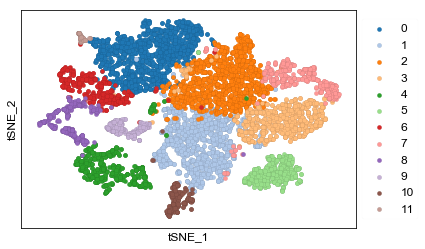

In [7]:
TSNEPlot(data=tsne.join(clusters), hue='cluster', palette=sns.color_palette('tab20', n_colors=12))

In [49]:
annot = {
    0: 'Late Primary Spermatocytes (0)',
    1: 'Early Somatic Cyst Cells (1)',
    2: 'Late Somatic Cyst Cells (2)',
    3: 'Late Somatic Cyst Cells (3)',
    4: 'Spermatogonia (4)',
    5: 'Terminal Epithelium (5)',
    6: 'Mid Primary Spermatocytes (6)',
    7: 'Late Somatic Cyst Cells (7)',
    8: 'Early Primary Spermatocytes (8)',
    9: 'Pigment Cells (9)',
    10: 'Early Somatic Cyst Cells (10)',
    11: 'Mid Primary Spermatocytes (11)',
}

In [50]:
_order = [
    'Spermatogonia (4)', 
    'Early Primary Spermatocytes (8)', 
    'Mid Primary Spermatocytes (6)', 
    'Mid Primary Spermatocytes (11)', 
    'Late Primary Spermatocytes (0)', 
    'Early Somatic Cyst Cells (1)', 
    'Early Somatic Cyst Cells (10)', 
    'Late Somatic Cyst Cells (2)', 
    'Late Somatic Cyst Cells (3)', 
    'Late Somatic Cyst Cells (7)', 
    'Terminal Epithelium (5)', 
    'Pigment Cells (9)',
]

In [51]:
dat = norm.T.join(clusters.apply(lambda x: annot[x])).groupby('cluster').sum().T[_order]

In [52]:
bio = pd.read_csv(Path(nbconfig.seurat_dir, 'biomarkers_0.4.tsv'), sep='\t')
sig_genes = bio[bio.p_val_adj < 0.001].primary_FBgn.unique().tolist()

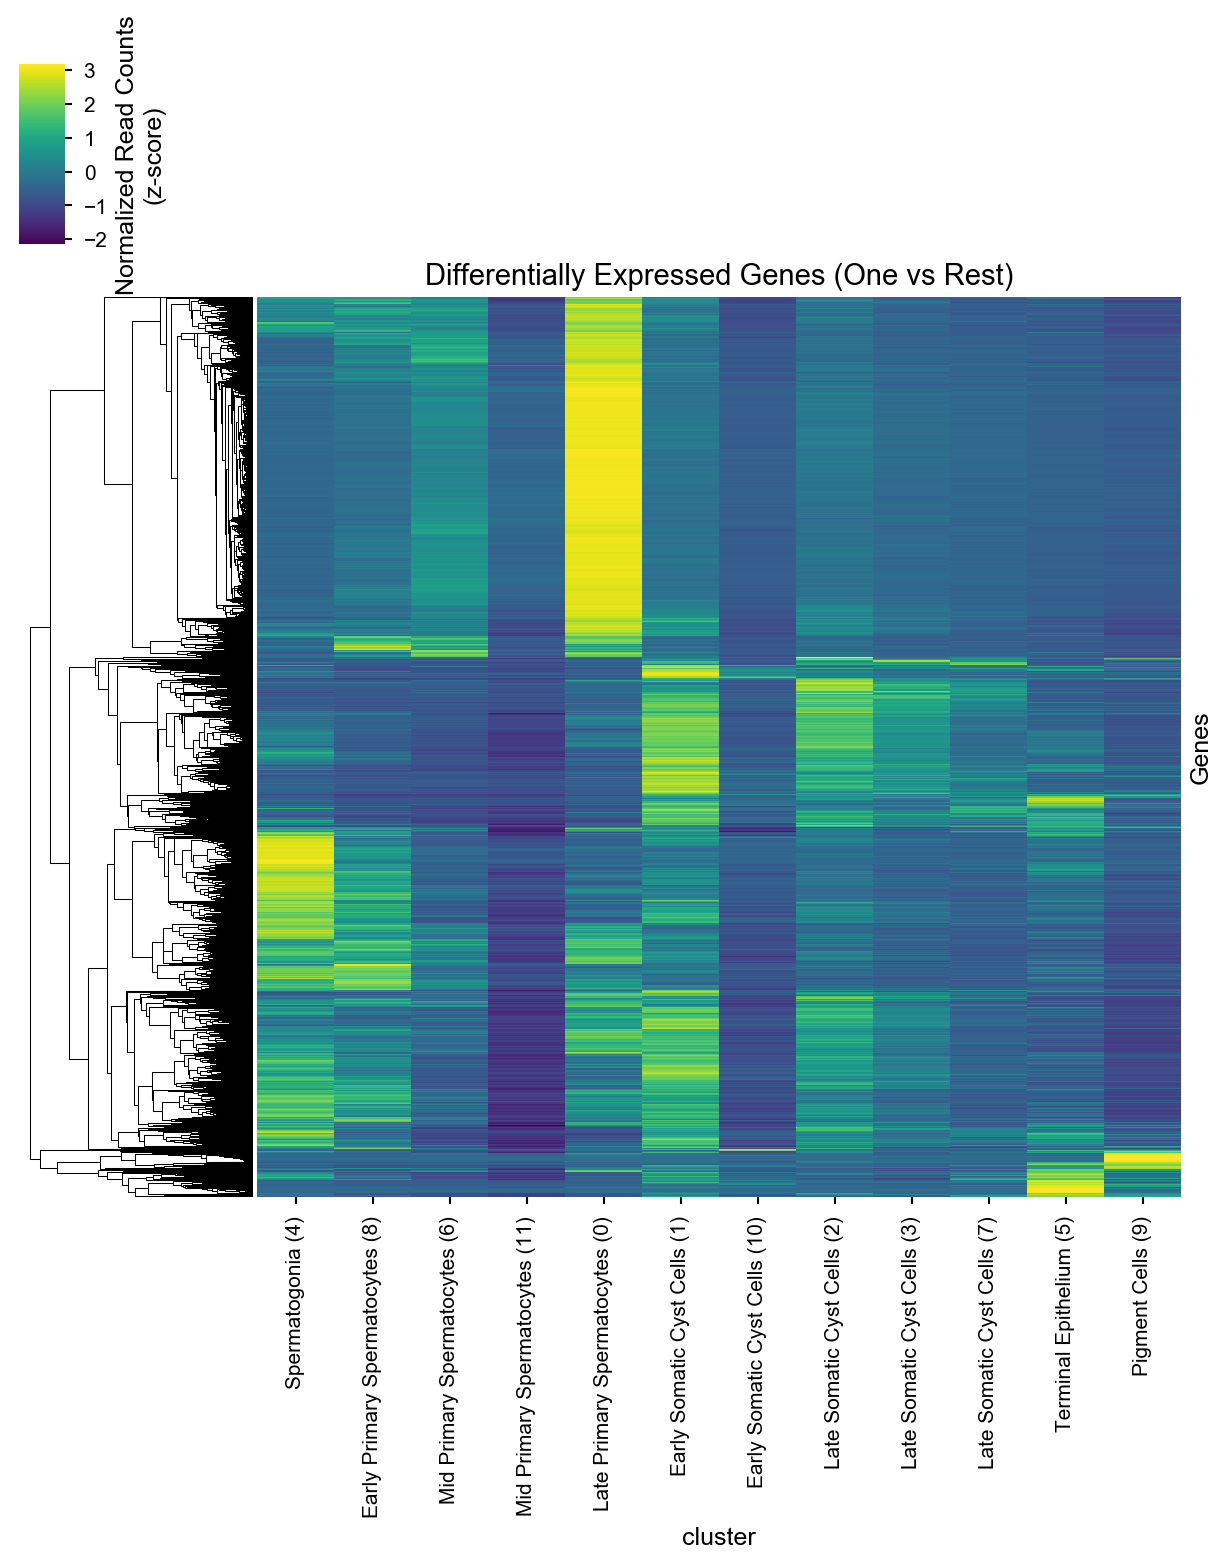

In [53]:
@make_figs(nbconfig.fig_name('heatmap_diff_genes'), styles=['notebook', 'paper'], formats='pdf', layout=False)
def _plot():
    g = sns.clustermap(dat[dat.index.isin(sig_genes)],
                       col_cluster=False, 
                       yticklabels=False, 
                       z_score=0,
                       cmap='viridis',
                       cbar_kws={'label': 'Normalized Read Counts\n(z-score)'},
                       rasterized=True,
                      )
    g.ax_heatmap.set_title('Differentially Expressed Genes (One vs Rest)')
    g.ax_heatmap.set_ylabel('Genes')
    
_plot()

In [54]:
cgs = []
for k, v in nbconfig.fbgn2symbol.items():
    if v.startswith('CG') | v.startswith('CR'):
        cgs.append(k)

In [55]:
top_10 = bio[~bio.primary_FBgn.isin(cgs)].sort_values(['cluster', 'p_val_adj', 'avg_logFC']).groupby('cluster').head(10).primary_FBgn.unique().tolist()

Text(0.5,1,'Top 10 Differentially Expressed Genes (One vs Rest)')

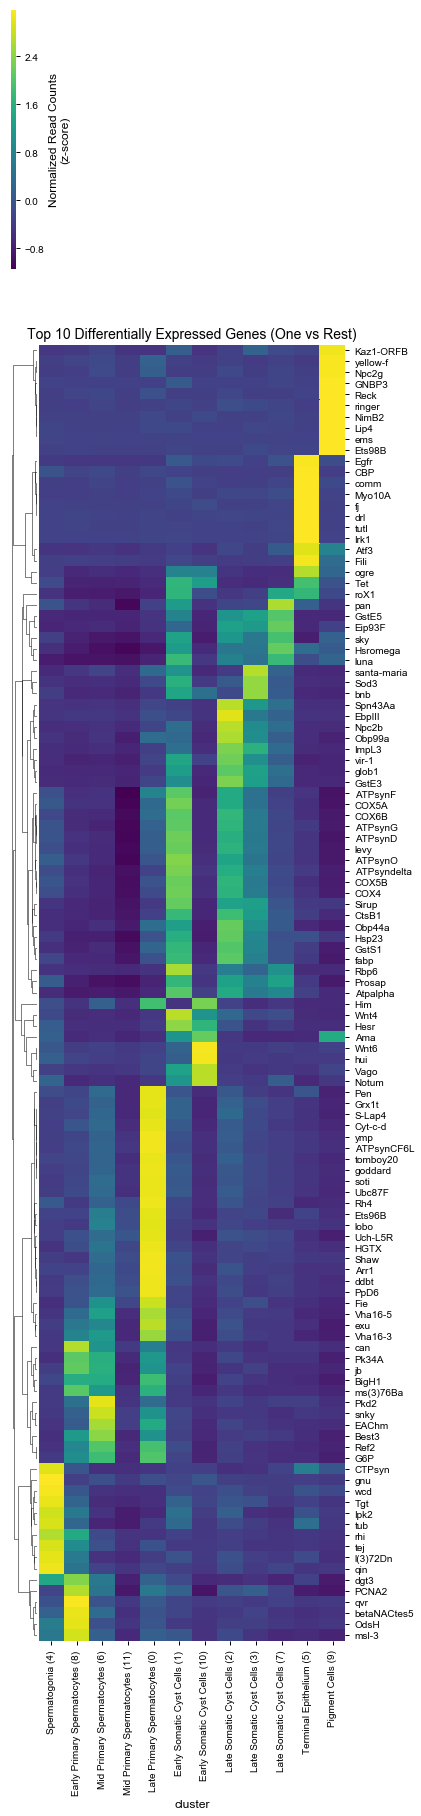

In [56]:
g = sns.clustermap(dat[dat.index.isin(top_10)],  
                   col_cluster=False,  
                   z_score=0, 
                   figsize=(6, 30), 
                   cmap='viridis',
                   cbar_kws={'label': 'Normalized Read Counts\n(z-score)'},
                   rasterized=True,
                  )

ax = g.ax_heatmap
new_labels = []
for l in ax.get_yticklabels():
    new_labels.append(nbconfig.fbgn2symbol[l.get_text()])
    
ax.set_yticklabels(new_labels);
ax.set_title('Top 10 Differentially Expressed Genes (One vs Rest)')

In [57]:
# literature

In [58]:
spermatogonia = [
    'vas',
    'bam',
    'p53'
]

early_primary_sperm = [
    'nht', 
    'can',
    'aly', 
]

late_primary_spermatocyte = [
    'fzo', 
    'soti', 
    'bol',
    'dj',
    'ocn',
]

early_soma = [
    'tj',
    'hui', 
    'sano', 
]

late_soma = [
    'eya', 
    'glob1', 
    'Eip93F', 
]


terminal = [
    'nord',
    'retn',
    'Abd-B',
]

pigment = [
    'vkg', 
    'Sox100B', 
    'bw',
]




In [59]:
select = []
for gene in spermatogonia + early_primary_sperm + late_primary_spermatocyte + early_soma + late_soma + terminal + pigment: 
    fbgn = nbconfig.symbol2fbgn[gene]
    if fbgn in dat.index:
        select.append(fbgn)

In [60]:
len(select)

23

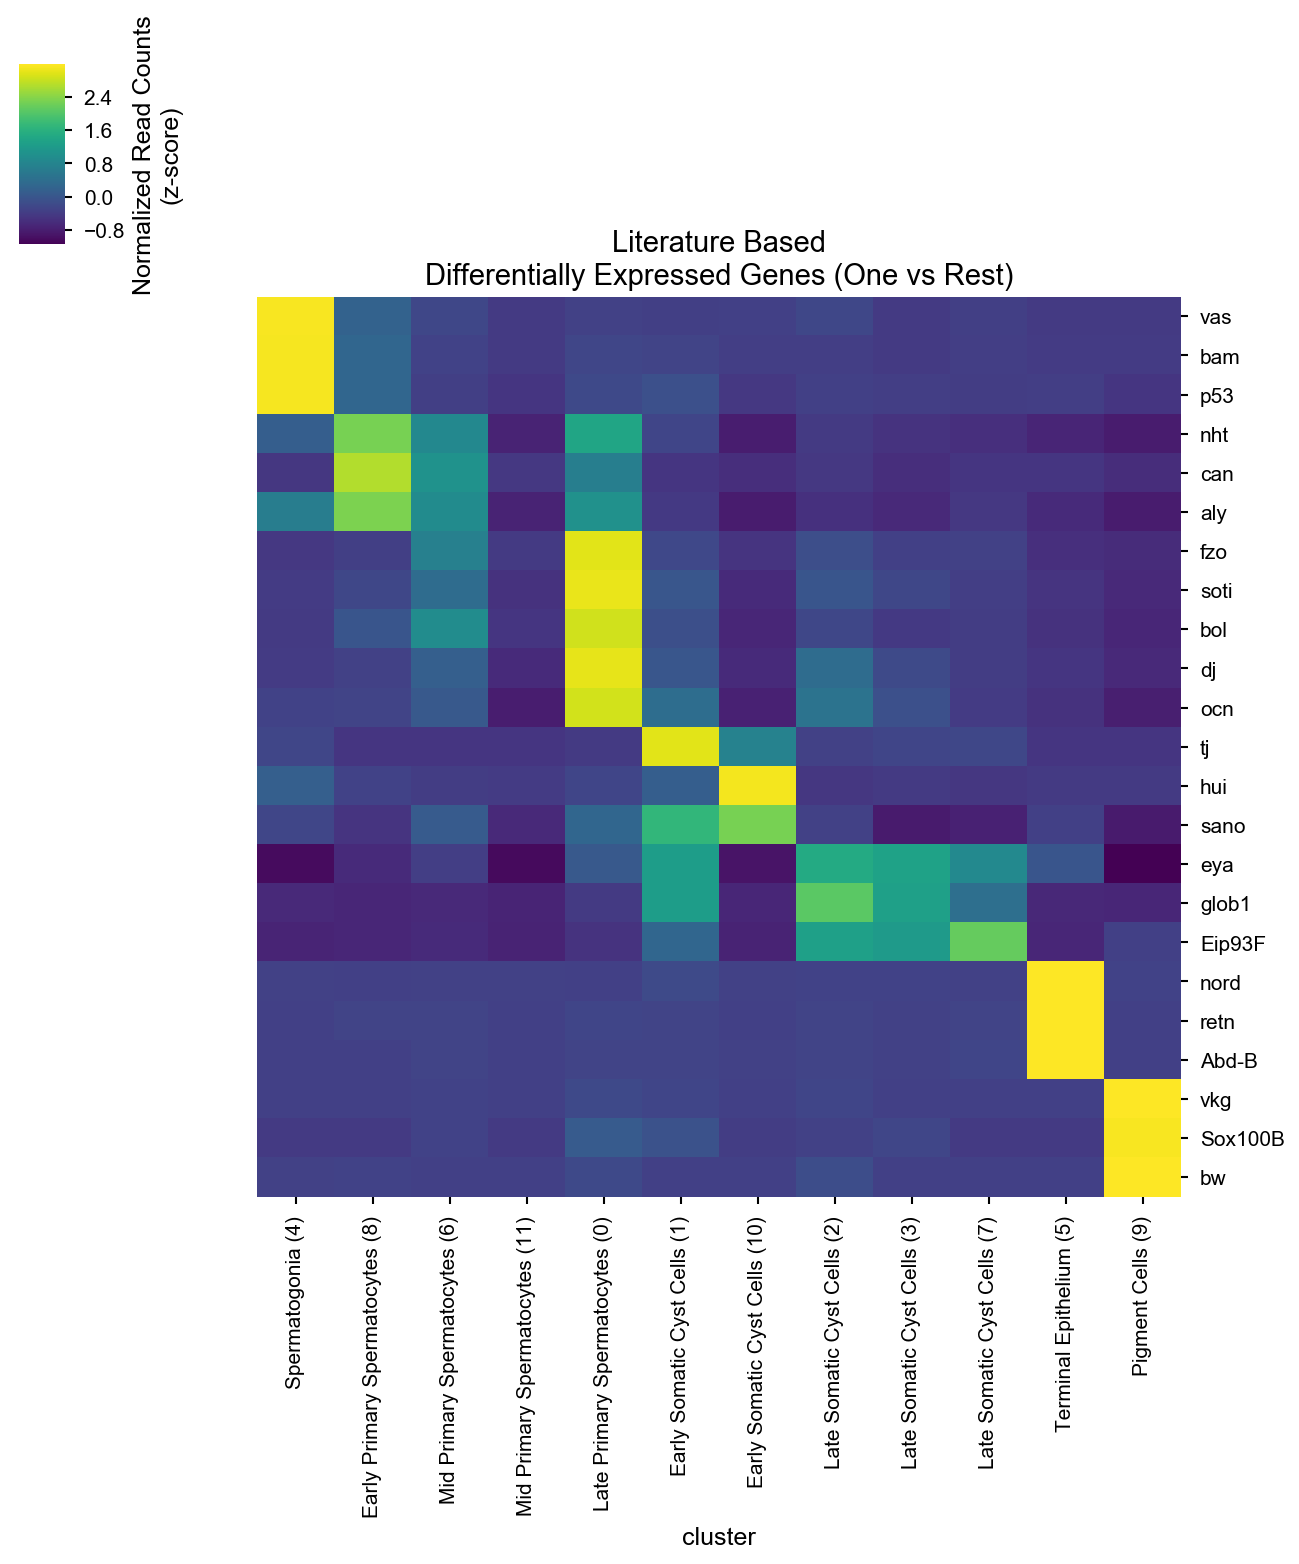

In [61]:
@make_figs(fname=nbconfig.fig_name('heatmap_literature_genes'), styles=nbconfig.styles,
           formats=nbconfig.formats,
           layout=False
          )
def _plot():
    g = sns.clustermap(dat.loc[select],  
                       col_cluster=False,  
                       row_cluster=False,  
                       z_score=0, 
                       cmap='viridis',
                       cbar_kws={'label': 'Normalized Read Counts\n(z-score)'},
                       rasterized=True,
                      )

    ax = g.ax_heatmap
    new_labels = []
    for l in ax.get_yticklabels():
        new_labels.append(nbconfig.fbgn2symbol[l.get_text()])

    ax.set_yticklabels(new_labels);
    ax.set_title('Literature Based\nDifferentially Expressed Genes (One vs Rest)')
    
_plot()